# Adapted from:  http://www.bioconductor.org/help/workflows/rnaseqGene/

#### To learn basics of R: https://www.datacamp.com/courses/free-introduction-to-r

# Table of Contents

1. [Setup](#Setup)
1. [Create DESeq Data Set](#Create-DESeq-Data-Set)
1. [Calculate TPM](#Calculate-TPM)
1. [PCA and Clustering](#PCA-and-Clustering)
    1. [PCA](#PCA)
    1. [Clustering](#Clustering)
1. [Find DEGs](#Find-DEGs)

# Setup

If this is your first time running this script, uncomment and run the following code block. This will install all necessary R packages, but it may take 5-10 minutes to complete

In [ ]:
# source("https://bioconductor.org/biocLite.R")
# biocLite('SummarizedExperiment')
# biocLite('GenomicFeatures')
# biocLite('DESeq2')
# biocLite('pheatmap')
# biocLite('RColorBrewer')

In [21]:
suppressPackageStartupMessages(library('SummarizedExperiment'))
suppressPackageStartupMessages(library('GenomicFeatures'))
suppressPackageStartupMessages(library('DESeq2'))

# Create DESeq Data Set

### From R pipeline

In [22]:
load('example/se.rda')

Create the DESeqDataSet, and designate the experimental design. The experimental design can include information from the colData. Use ~1 to ignore design criteria.

In [23]:
colnames(se)

[1] "wt_fe2_1"     "wt_fe2_2"     "wt_dpd_1"     "wt_dpd_2"     "delfur_fe2_1"
[6] "delfur_fe2_2" "delfur_dpd_1" "delfur_dpd_2"

In [24]:
# Designate groups for comparisons by removing the replicate subscript from colnames
colData(se)$group <- gsub('.{2}$', '', colnames(se))
colData(se)$group

[1] "wt_fe2"     "wt_fe2"     "wt_dpd"     "wt_dpd"     "delfur_fe2"
[6] "delfur_fe2" "delfur_dpd" "delfur_dpd"

In [25]:
dds <- DESeqDataSet(se, design = ~group)

Warning message in DESeqDataSet(se, design = ~group):
“some variables in design formula are characters, converting to factors”

Remove genes that have 0 counts across experimental conditions

In [26]:
nrow(dds)
dds <- dds[rowSums(assay(dds)) > 1, ]
nrow(dds)

[1] 4319

[1] 4270

In [27]:
assay(dds)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,2303,2354,311,284,3019,3485,245,232
b0002,36937,25801,58117,60901,40532,38470,17890,23112
b0003,10922,8250,16854,21042,11589,10840,4805,7879
b0004,11953,8463,12127,14498,10077,9532,3727,5103
b0005,472,345,216,178,362,297,104,120
b0006,669,588,703,633,682,653,660,767
b0007,116,101,134,120,117,112,161,138
b0008,15470,13532,16026,12204,15773,14951,12826,12494
b0009,358,321,459,403,411,324,407,410
b0010,123,111,72,64,85,82,110,67


## From Python pipeline

In [28]:
countdata <- read.csv(file='example/counts.csv',row.names=1)

In [29]:
coldata <- read.csv(file='example/metadata.csv')

In [30]:
coldata$group <- gsub('.{2}$', '', coldata$sample_id)

In [31]:
GFF_FILE <- "./example/ref/NC_000913.3.gff"
txdb <- makeTxDbFromGFF(GFF_FILE, format="gtf")
exons <- exonsBy(txdb, by="gene")

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message:
“Named parameters not used in query: internal_chrom_id, chrom, length, is_circular”Warning message:
“Named parameters not used in query: internal_id, name, type, chrom, strand, start, end”Warning message:
“Named parameters not used in query: internal_id, name, chrom, strand, start, end”Warning message:
“Named parameters not used in query: internal_tx_id, exon_rank, internal_exon_id, internal_cds_id”Warning message:
“Named parameters not used in query: gene_id, internal_tx_id”OK


In [32]:
dds2 <- DESeqDataSetFromMatrix(countData = countdata,
                              colData = coldata,
                              design = ~group,
                              rowRanges = exons[rownames(countdata)])

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

In [ ]:
head(assay(dds))

In [34]:
head(assay(dds2))

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,4134,4226,311,447,5277,6196,358,368
b0002,76008,52897,58117,127141,82980,78532,36899,48026
b0003,26803,19819,16854,52019,27615,25772,12258,19451
b0004,26024,18376,12127,31955,21903,20725,8593,11451
b0005,738,528,216,278,578,463,182,198
b0006,1304,1138,703,1209,1318,1268,1259,1461


# Calculate TPM

In [61]:
fpkm_data <- fpkm(dds)
head(fpkm_data)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,4106.7522,5045.3267,433.16027,398.30296,4974.6676,6096.7173,290.03315,296.46774
b0002,2053.1535,1717.2161,2635.56977,3080.53209,2127.0833,2101.1904,812.85544,1052.05911
b0003,1910.0263,1697.3424,2502.66173,3325.03286,1867.4541,1819.1173,712.38073,1124.08587
b0004,1344.8103,1141.2209,1169.43185,1481.16615,1074.0871,1060.8113,362.13322,479.87926
b0005,164.8325,141.7269,62.22036,55.69412,122.5077,102.4293,33.15084,35.86356
b0006,111.5580,117.0031,91.39236,92.77426,107.0009,107.4482,87.83863,101.36197


In [62]:
tpm_data <- sweep(fpkm_data,2,colSums(fpkm_data),`/`)*1e6 # Divide each column by the column sum (times 1e6)
head(tpm_data)

,wt_fe2_1,wt_fe2_2,wt_dpd_1,wt_dpd_2,delfur_fe2_1,delfur_fe2_2,delfur_dpd_1,delfur_dpd_2
b0001,2826.95054,3490.55060,377.86153,349.10610,3939.03848,4848.54671,249.61259,252.04908
b0002,1413.32207,1188.03596,2299.10381,2700.03648,1684.26591,1671.01725,699.57159,894.43299
b0003,1314.79811,1174.28661,2183.16327,2914.33744,1478.68649,1446.69248,613.09957,955.66824
b0004,925.72230,789.54042,1020.13813,1298.21813,850.48307,843.63318,311.66441,407.98073
b0005,113.46519,98.05210,54.27709,48.81499,97.00397,81.45912,28.53076,30.49025
b0006,76.79281,80.94722,79.72490,81.31514,84.72542,85.45051,75.59697,86.17528


In [10]:
write.csv(tpm_data, file = "example/deseq2-tpm.csv")

# PCA and clustering

Raw counts from RNAseq tend to be exponentially distributed, so a log transform must be applied before running linear methods such as PCA or clustering. Since some counts can be 0, we must apply log(x + 1) to avoid infinite values. However, due to technical reasons, genes with lower counts have higher variance than genes with higher counts. PCA works best with constant variance, so to fix this DESeq2 has a model-based regularized log transform (rlog) to normalize the variance. The rlog counts are only used for this QC step, and should not be used for finding DEGs or other statistical tests.

In [11]:
rld <- rlog(dds)

In [12]:
library("pheatmap")
library("RColorBrewer")

## PCA

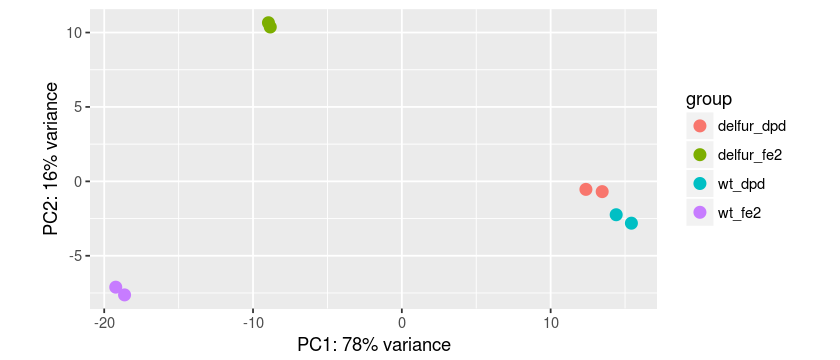

In [13]:
options(repr.plot.width=7, repr.plot.height=3)
plotPCA(rld,intgroup=c('group'))

## Clustering

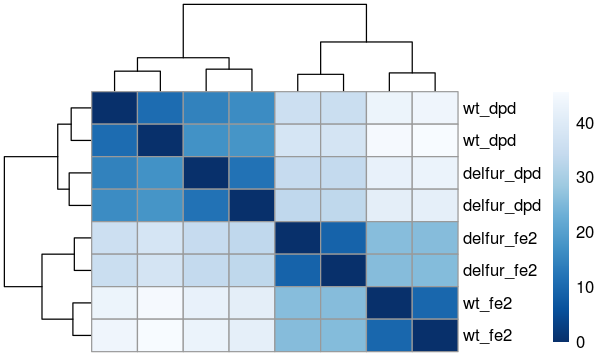

In [14]:
options(repr.plot.width=5, repr.plot.height=3)
# Generate (euclidean) distance matrix
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix( sampleDists )
# Designate the names for the rows
rownames(sampleDistMatrix) <- colData(rld)$group
# Designate the names for the columns
colnames(sampleDistMatrix) <- NULL
# Choose color palette
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
# Create heatmap
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sampleDists,
         clustering_distance_cols = sampleDists,
         col = colors)

# Find DEGs

In [15]:
dds <- DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Designate which groups you want to compare for DEGs

In [16]:
res_FeCl2 <- results(dds,contrast = c('group','wt_fe2','delfur_fe2'))
res_DPD <- results(dds,contrast = c('group','wt_dpd','delfur_dpd'))

Put results into table form

In [17]:
resTable_FeCl2 <- data.frame(res_FeCl2@listData,row.names = res_FeCl2@rownames)
resTable_DPD <- data.frame(res_DPD@listData,row.names = res_DPD@rownames)

In [18]:
head(resTable_FeCl2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b0001,1639.1251,-0.29108132,0.1395702,-2.0855546,0.037018984,0.13266283
b0002,37542.6022,-0.16292124,0.1373759,-1.1859524,0.235641112,0.49597824
b0003,11469.7950,-0.05210016,0.1880405,-0.2770689,0.781727234,0.90848108
b0004,9537.3314,0.22528062,0.1592775,1.4143909,0.157247165,0.37852128
b0005,272.6053,0.47939480,0.1710197,2.8031560,0.005060518,0.02633381
b0006,666.5451,0.09461495,0.1295187,0.7305121,0.465077235,0.72268510


In [19]:
deg_FeCl2 <- resTable_FeCl2[complete.cases(resTable_FeCl2[,c('padj','log2FoldChange')]) & 
                            # ^ Make sure that LogFoldChange and p-adjusted are complete (not null)
                            resTable_FeCl2$padj < .05 & # Adjusted p-value cutoff of 0.05
                            abs(resTable_FeCl2$log2FoldChange) > 1,] # abs(log2foldChange) cutoff of 1

deg_DPD <- resTable_DPD[complete.cases(resTable_DPD[,c('padj','log2FoldChange')]) & 
                        # ^ Make sure that LogFoldChange and p-adjusted are complete (not null)
                        resTable_DPD$padj < .05 & # Adjusted p-value cutoff of 0.05
                        abs(resTable_DPD$log2FoldChange) > 1,] # abs(log2foldChange) cutoff of 1

In [20]:
head(deg_FeCl2)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b0034,166.2879,1.127988,0.21046357,5.359542,8.343335e-08,1.214034e-06
b0118,24650.1372,1.324849,0.09947515,13.318394,1.809595e-40,8.722249e-39
b0123,3273.5336,2.046491,0.11783836,17.366937,1.468591e-67,1.348306e-65
b0150,7194.8108,-1.101286,0.14720093,-7.481517,7.346954e-14,1.628153e-12
b0152,424.5647,-1.053181,0.17091003,-6.162194,7.174390e-10,1.257475e-08
b0273,3502.7665,1.179236,0.20566736,5.733703,9.826115e-09,1.591996e-07
